In [1]:
import pandas as pd
import numpy as np
import networkx as nx

# Loading input data

In [2]:
data_path = "/media/visionin/data_station/OctanData/AWS_SYNC/ETHER/part-00000-0a952bea-b75a-47fb-822a-298745a389ef-c000.csv"

In [3]:
data_df = pd.read_csv(data_path)

/tmp/ipykernel_19093/391930957.py:1: DtypeWarning: Columns (6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv(data_path)


In [4]:
len(data_df)

2283751

In [9]:
data_df.head(5)

,block_number,from_address,to_address,gas,gas_used,gas_price,value,token_transfer,token_contract,volume,gas_spent,gas_spent_usd
0,16551701,0x68cc21f7c777243d1a9c71c2349bfdccd8ca7b78,0xe8c060f8052e07423f71d445277c61ac5138a2e5,352525,280678,19006170243,0,NaN,NaN,0.000000e+00,0.005335,8.879317
1,16551701,0x4191131cd452e9729546b79f9f4e00c12e1d1c22,0x1111111254eeb25477b68fb85ed929f73a960582,1035120,697882,20017190718,0,NaN,NaN,0.000000e+00,0.013970,23.252074
2,16551701,0x68cc21f7c777243d1a9c71c2349bfdccd8ca7b78,0xe8c060f8052e07423f71d445277c61ac5138a2e5,348594,277072,19006170243,0,NaN,NaN,0.000000e+00,0.005266,8.765240
3,16551701,0x00000027f490acee7f11ab5fdd47209d6422c5a7,0xa7003527af20001c000037a90051b19ce31eed36,170660,85330,19006170243,327792709,NaN,NaN,5.456000e-07,0.001622,2.699435
4,16551701,0x34d79ac362a199b3756538732e7c0b3f599cd442,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,193341,118808,21006170243,5000000000000000000,NaN,NaN,8.322361e+03,0.002496,4.154025


# Features Extracting

In [10]:
extract_data_df = data_df[['block_number','from_address','to_address','volume','gas_spent_usd']]

In [11]:
extract_data_df.head(5)

,block_number,from_address,to_address,volume,gas_spent_usd
0,16551701,0x68cc21f7c777243d1a9c71c2349bfdccd8ca7b78,0xe8c060f8052e07423f71d445277c61ac5138a2e5,0.000000e+00,8.879317
1,16551701,0x4191131cd452e9729546b79f9f4e00c12e1d1c22,0x1111111254eeb25477b68fb85ed929f73a960582,0.000000e+00,23.252074
2,16551701,0x68cc21f7c777243d1a9c71c2349bfdccd8ca7b78,0xe8c060f8052e07423f71d445277c61ac5138a2e5,0.000000e+00,8.765240
3,16551701,0x00000027f490acee7f11ab5fdd47209d6422c5a7,0xa7003527af20001c000037a90051b19ce31eed36,5.456000e-07,2.699435
4,16551701,0x34d79ac362a199b3756538732e7c0b3f599cd442,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,8.322361e+03,4.154025


In [12]:
# transfer_value = volume + gas_spent
extract_data_df['gas_volume_sum'] = extract_data_df.apply(lambda row: row['volume']+row['gas_spent_usd'], axis=1)

/tmp/ipykernel_19093/504634310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_data_df['gas_volume_sum'] = extract_data_df.apply(lambda row: row['volume']+row['gas_spent_usd'], axis=1)


# Define weighting functions

In [15]:
"""
1. Edges weights
Y = SUM(T*V)
where:
    T: activeness weight
    V: tanh value of transaction
"""
def tanh_function(x,
             a=2,
             b=1/512):
    """
    V: convert transfer value to tanh value
    """
    return a / (1.0 + np.exp(-b * x))-1

def logistic(x,
             a=1,
             b=1 / 64):
    """Logistic function"""
    return a / (1.0 + np.exp(-b * x))

# logistic local weights
def logistic_local_timestamp_weights(block_max, block_min, blocks_per_day=28800, active_time=90):
    """
    T: Activeness function
    """
    timestamp_range = [i for i in range(int((block_max-block_min)/blocks_per_day)+1)]
    origin = timestamp_range[-1] - active_time
    weights_dict = dict()
    for timestamp in timestamp_range:
        if timestamp not in weights_dict.keys():
            edge_weight = logistic(timestamp-origin)
            weights_dict[timestamp] = edge_weight
    return weights_dict

# Apply tanh value

In [14]:
# convert tanh value
extract_data_df.head(5)

,block_number,from_address,to_address,volume,gas_spent_usd,gas_volume_sum
0,16551701,0x68cc21f7c777243d1a9c71c2349bfdccd8ca7b78,0xe8c060f8052e07423f71d445277c61ac5138a2e5,0.000000e+00,8.879317,8.879317
1,16551701,0x4191131cd452e9729546b79f9f4e00c12e1d1c22,0x1111111254eeb25477b68fb85ed929f73a960582,0.000000e+00,23.252074,23.252074
2,16551701,0x68cc21f7c777243d1a9c71c2349bfdccd8ca7b78,0xe8c060f8052e07423f71d445277c61ac5138a2e5,0.000000e+00,8.765240,8.765240
3,16551701,0x00000027f490acee7f11ab5fdd47209d6422c5a7,0xa7003527af20001c000037a90051b19ce31eed36,5.456000e-07,2.699435,2.699436
4,16551701,0x34d79ac362a199b3756538732e7c0b3f599cd442,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,8.322361e+03,4.154025,8326.515493


In [16]:
extract_data_df['tanh_value'] = extract_data_df.apply(lambda row: tanh_function(row['gas_volume_sum']), axis=1)

/tmp/ipykernel_19093/3228226531.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_data_df['tanh_value'] = extract_data_df.apply(lambda row: tanh_function(row['gas_volume_sum']), axis=1)


# Apply acitiveness function

In [19]:
max_block = extract_data_df['block_number'].max()
max_block

16558856

In [20]:
# check logistic weight distribution
import matplotlib.pyplot as plt
# Ethereum: 1 block ~ 12 seconds => 1 days ~ 7200 blocks
weights_dict = logistic_local_timestamp_weights(max_block, 0, blocks_per_day=7200, active_time=90)
edge_weights = []

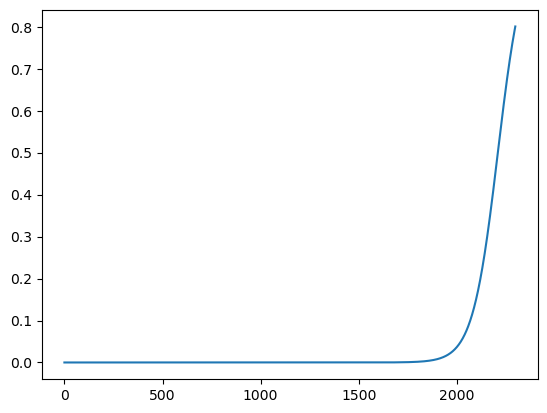

In [22]:
# plot activeness weights 
for i in range(int((max_block)/7200)):
    if weights_dict[i] not in edge_weights:
        edge_weights.append(weights_dict[i])

# plot weights distribution
plt.plot(edge_weights)
plt.show()

In [23]:
extract_data_df["activeness_weights"] = extract_data_df.apply(lambda row: weights_dict[int(row['block_number']/7200)], axis=1)

/tmp/ipykernel_19093/1992391269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_data_df["activeness_weights"] = extract_data_df.apply(lambda row: weights_dict[int(row['block_number']/7200)], axis=1)


# Edge weighting (value weighting)

In [26]:
extract_data_df['value_weights'] = extract_data_df.apply(lambda row: row['tanh_value']*row['activeness_weights'], axis=1)

/tmp/ipykernel_19093/2950818329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_data_df['value_weights'] = extract_data_df.apply(lambda row: row['tanh_value']*row['activeness_weights'], axis=1)


In [28]:
value_weights_graph_df = extract_data_df[['from_address', 'to_address','value_weights']]

In [29]:
sum_value_weights_graph_df = value_weights_graph_df.groupby(["from_address", "to_address"])['value_weights'].sum().reset_index()

# Node weighting - personalized vector

In [30]:

extract_data_df.sort_values('activeness_weights', inplace=True, ascending=True)


/tmp/ipykernel_19093/1299979268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extract_data_df.sort_values('activeness_weights', inplace=True, ascending=True)


In [31]:
ether_drop_dup_df = extract_data_df.drop_duplicates(subset=['from_address','to_address'], keep='last')

In [32]:
len(ether_drop_dup_df)

1229961

In [33]:
# data processing df_data_remove_loop
# extract features
to_weights_df = ether_drop_dup_df[['to_address', 'activeness_weights']]

# group receiver
node_age_weights = to_weights_df.groupby('to_address').sum()

# sum calculation
# sum of weights
s_weights = float(node_age_weights["activeness_weights"].sum())

# personalized dict
personalized_vector = {k: v/s_weights for k, v in node_age_weights["activeness_weights"].items()}

# Init graph

In [34]:
import time
start_time = time.time()
ether_graph = nx.from_pandas_edgelist(sum_value_weights_graph_df, source="from_address", target="to_address", edge_attr="value_weights", create_using=nx.DiGraph())
print(time.time() - start_time, "s")

6.084091901779175 s


# Reputation Scores

In [35]:
start_time = time.time()
pg_scores = nx.pagerank(ether_graph, alpha=0.5, personalization=personalized_vector, weight="value_weights")
print(time.time()-start_time, "s")

5.3642919063568115 s


In [36]:
# create node list table
ranking = pd.DataFrame(pg_scores.items(), columns=['Address', 'Reputation Scores'])

In [38]:
ranking.sort_values('Reputation Scores', inplace=True, ascending=False)


In [39]:
ranking.head(5)

,Address,Reputation Scores
77653,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0.036479
77958,0x28c6c06298d514db089934071355e5743bf21d60,0.022117
77362,0x00000000006c3852cbef3e08e8df289169ede581,0.022027
77652,0xdac17f958d2ee523a2206206994597c13d831ec7,0.020748
77680,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0.010387
